## Diffusion Model

- 这个名字想必大家都听过吧，21年火到爆了，现在研究人也相当多
- 那他主要都能做啥呢，咱们先来上几个菜尝尝咸淡

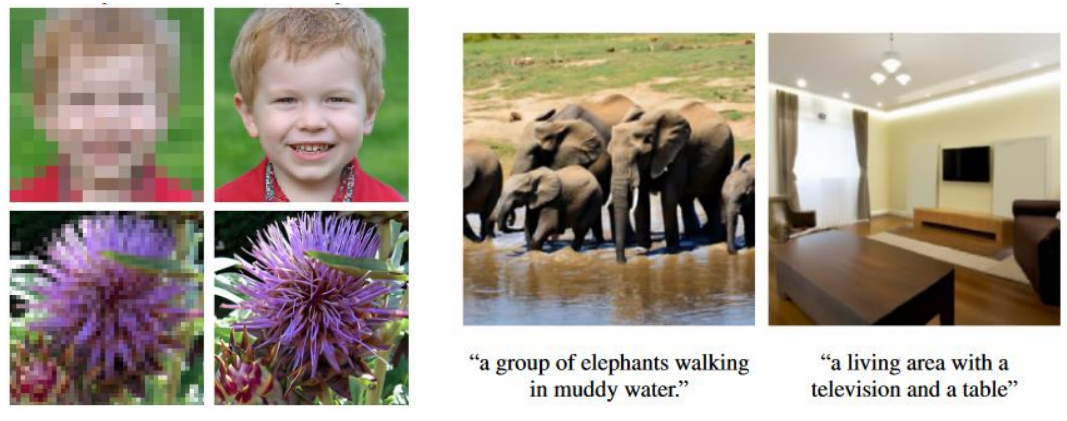

目前主要来看还是图像生成多，比如Dalle2等

### 以前总说GAN，现在改朝换代了？
- 孰是孰非还得再等等，目前来看主流的生成模型已经不咋用GAN了，最新的都是Diffusion Model
- GAN要训练俩网络，感觉难度较大，容易不收敛，而且多样性比较差，只关注能骗过判别器就得了
- Diffusion Model用一种更简单的方法来诠释了生成模型该如何学习以及生成，其实感觉更简单

DDPM 论文连接，咱们主要就基于这个来讲 ([Ho et al., 2020](https://arxiv.org/abs/2006.11239))

### Diffusion现身吧
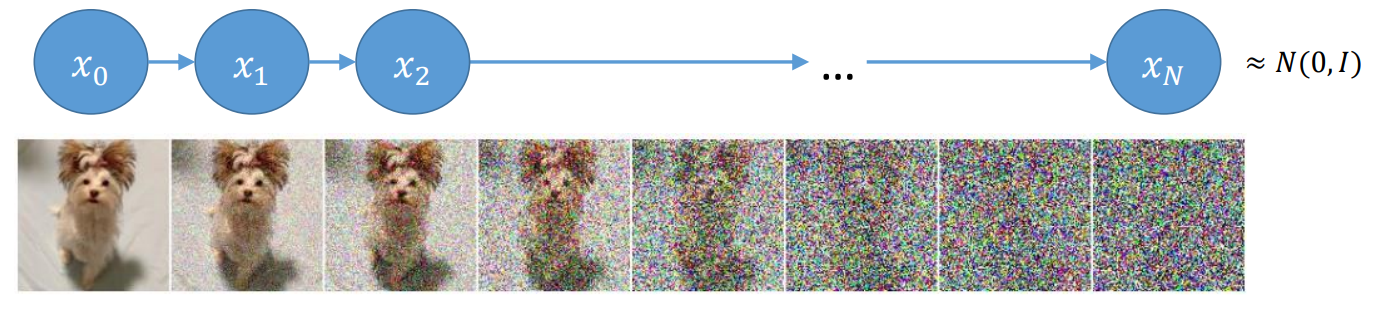

- 这里咱们先看前向过程，其实就是不断往输入数据中加噪声，最后就快变成了个纯噪声
- 每一个时刻都要添加高斯噪声，后一时刻都是由前一刻是增加噪声得到
- 其实这个过程可以看过咱们不断构建标签（噪声）的过程，后续会用到

### 第一个重要公式，如何得到Xt时刻的分布呢（前向过程）

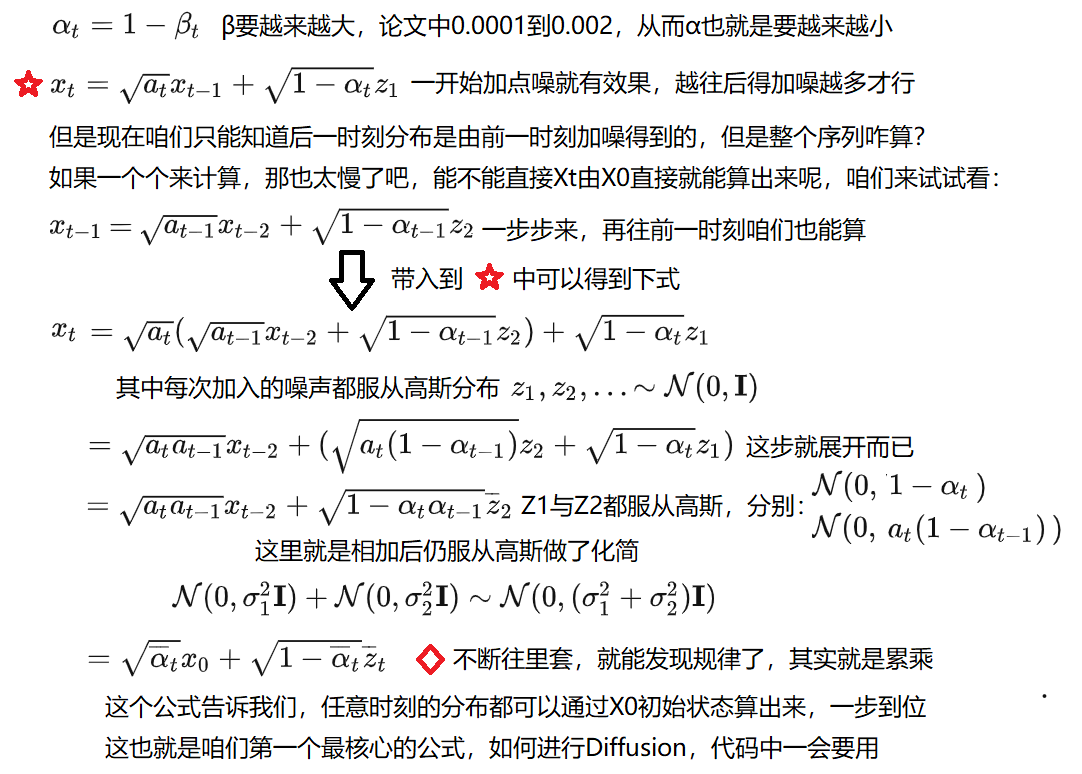

### 咱们现在能加噪了，但是目的却是去噪生成，接下来就是逆向过程

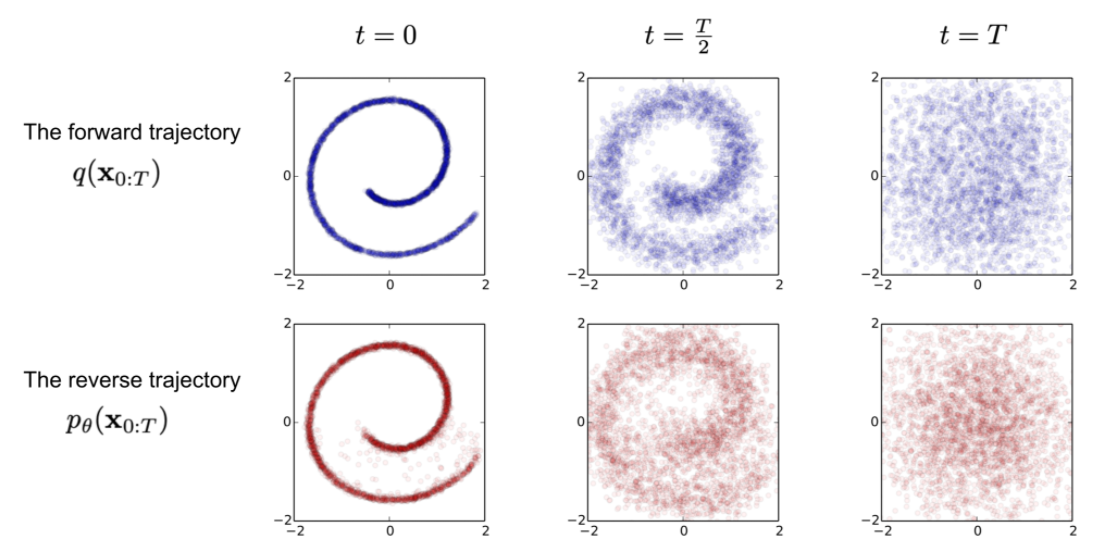

### 逆向第一步，先看看咱们要求解啥，该咋求呢？
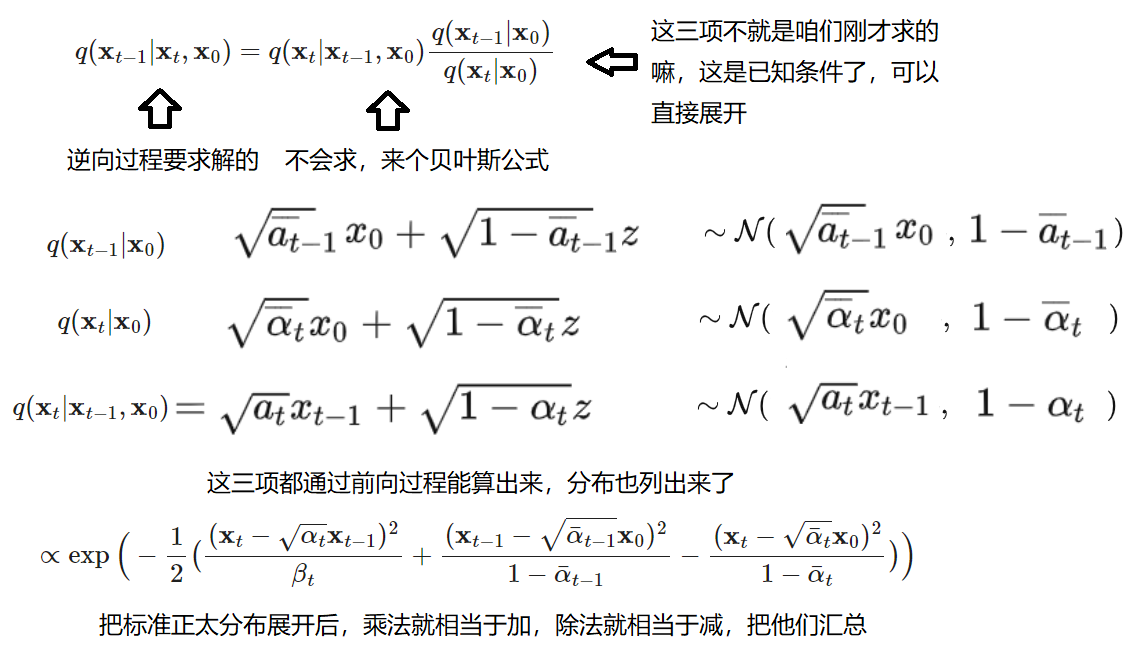

#### 接下来继续化简，咱们现在要求的是上一时刻的分布
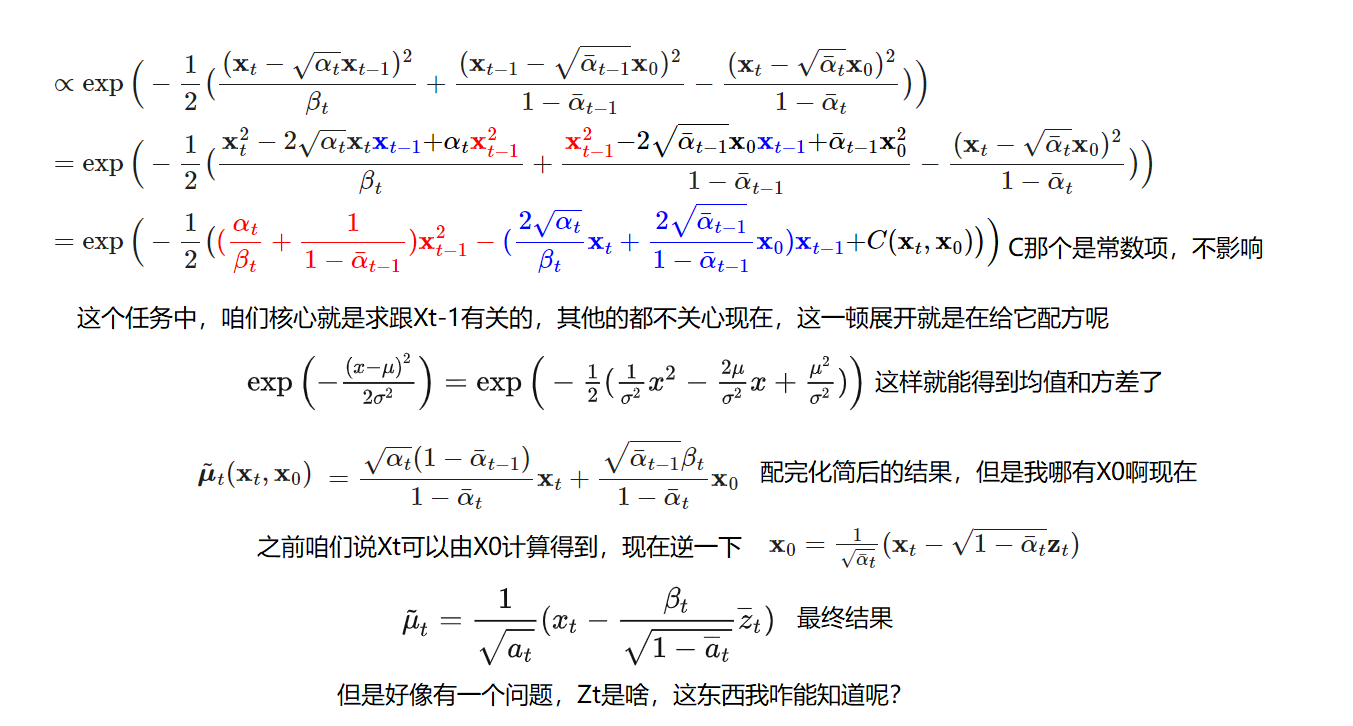

### Zt其实就是我们要估计的每个时刻的噪声
- 这家伙看起来无法直接求解，我们只能训练一个模型来计算了
- 这些相关论文里竟然都用Unet这种结构来玩的，可能是编码和解码看着比较舒服
- 模型的输入参数有两个，分别是当前时刻的分布和时刻t

## 接下来把这俩阶段汇总到一起，就是终极流程图了
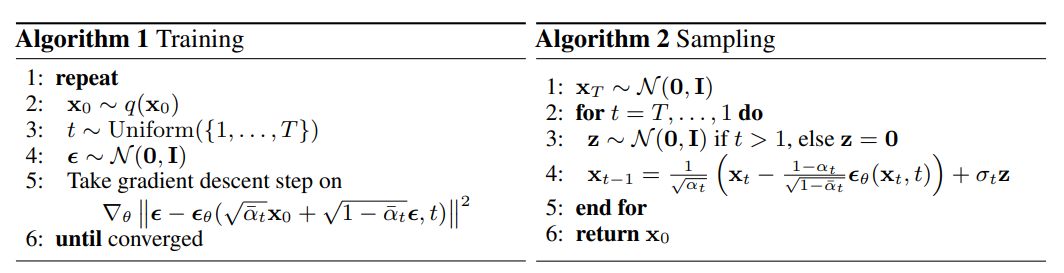

分别对应咱们的前向和后向过程

In [27]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

辅助函数

In [28]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### 对时刻T做位置编码映射
- 因为每次计算噪声的时候都需要传入时刻t，那每次应该都得不一样才行
- 下面代码就是transformer中的正余弦编码

In [29]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### 网络结构定义
- 这里是Unet，感觉啥都行吧，就预测一个噪声而已

In [30]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

### 额外加了一些注意力机制
- 没啥特别的，跟之前讲的注意力模块一样



In [31]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization
- 给穷人(我)用的，不受Batch大小影响

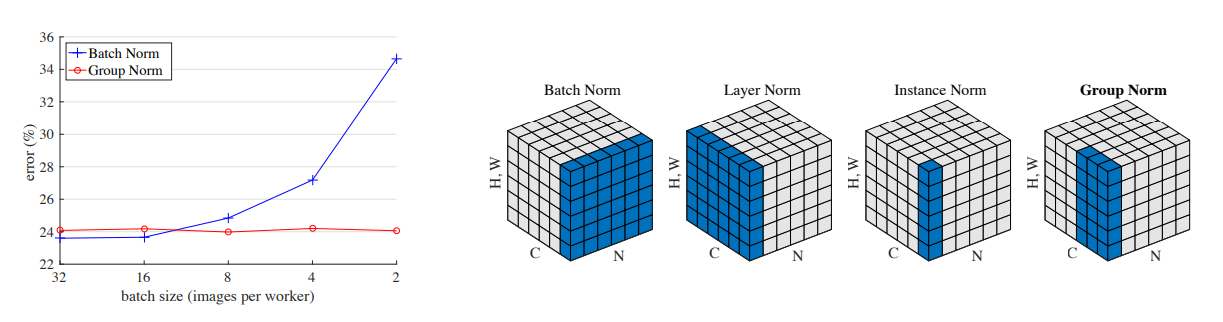

In [32]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### U-Net
- 这名字大家太熟悉了

In [33]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

### forward diffusion process

- 衰减策略:

> 线性衰减也可以的，从 $\beta_1 = 10^{−4}$ 到 $\beta_T = 0.02$.

当然其他衰减方法也可以的，下面列出来多种可以选择

In [34]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

把咱们上面推导的公式中所涉及的输入量都先定义好，因为这些已经都能求出来了


In [35]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

### 整个图，看看这个流程

In [36]:
from PIL import Image

image = Image.open('000000039769.jpg')
#image

先做一些基本预处理

In [37]:
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize

image_size = 128
transform = Compose([
    Resize(image_size),
    CenterCrop(image_size),
    ToTensor(), # turn into Numpy array of shape HWC, divide by 255
    Lambda(lambda t: (t * 2) - 1),#取值在-1到1之间
    
])

x_start = transform(image).unsqueeze(0)
x_start.shape

torch.Size([1, 3, 128, 128])

In [38]:
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2),
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

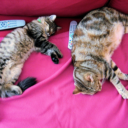

In [39]:
reverse_transform(x_start.squeeze())

In [40]:
# forward diffusion，就是咱们第一个公式
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [41]:
def get_noisy_image(x_start, t):
    # add noise
    x_noisy = q_sample(x_start, t=t)

    # turn back into PIL image
    noisy_image = reverse_transform(x_noisy.squeeze())

    return noisy_image

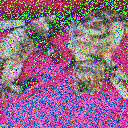

In [42]:
# take time step
t = torch.tensor([40])

get_noisy_image(x_start, t)

下面咱们把这个过程都展示一下

In [43]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

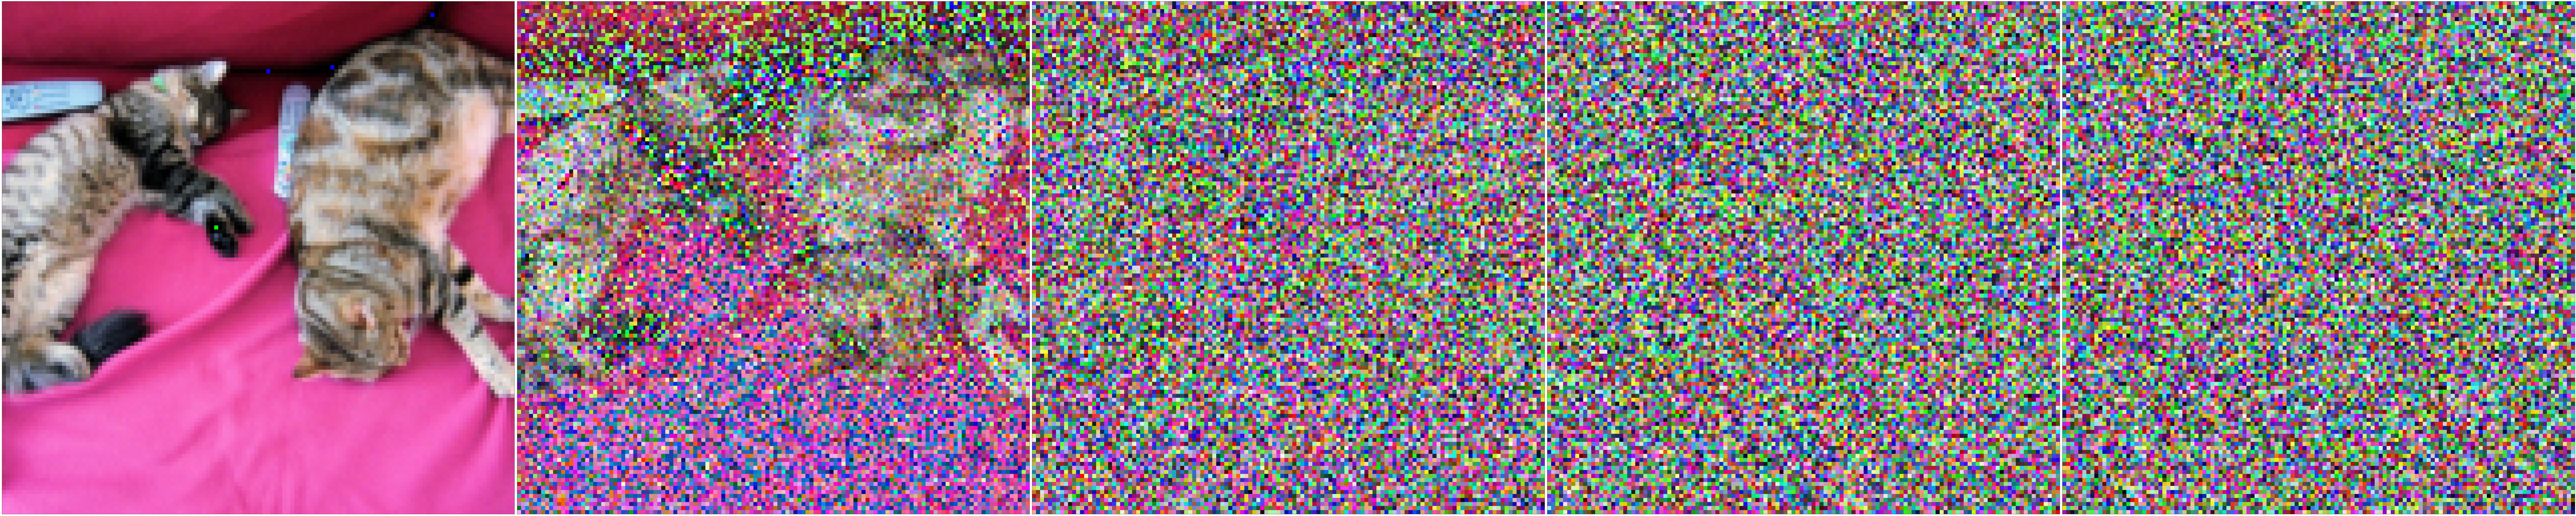

In [44]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

损失计算模块（预测噪声那）

In [45]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

咱们用Fashion MNIST dataset，这个比较小，好训练一点，数据集 [链接](https://huggingface.co/datasets/fashion_mnist)

In [46]:
from datasets import load_dataset #自备梯子

# load dataset from the hub
dataset = load_dataset("fashion_mnist")
image_size = 28
channels = 1
batch_size = 128

Reusing dataset fashion_mnist (C:\Users\Administrator\.cache\huggingface\datasets\fashion_mnist\fashion_mnist\1.0.0\8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1)


A Jupyter Widget

基本预处理

In [47]:
from torchvision import transforms
from torch.utils.data import DataLoader

# define image transformations (e.g. using torchvision)
transform = Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Lambda(lambda t: (t * 2) - 1)
])

# define function
def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]

    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [48]:
batch = next(iter(dataloader))
print(batch.keys())

dict_keys(['pixel_values'])


### 接下来就是不断还原的过程了
- 全部都是对应咱们之前讲的公式的

In [49]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))


Note that the code above is a simplified version of the original implementation. We found our simplification (which is in line with Algorithm 2 in the paper) to work just as well as the [original, more complex implementation](https://github.com/hojonathanho/diffusion/blob/master/diffusion_tf/diffusion_utils.py).


## Train the model

Next, we train the model in regular PyTorch fashion. We also define some logic to peridiocally save generated images, using the `sample` method defined above.


In [50]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

Below, we define the model, and move it to the GPU. We also define a standard optimizer (Adam).

In [51]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

Let's start training!

In [52]:
from torchvision.utils import save_image

epochs = 15

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
        optimizer.zero_grad()

        batch_size = batch["pixel_values"].shape[0]
        batch = batch["pixel_values"].to(device)

          # Algorithm 1 line 3: sample t uniformally for every example in the batch
        t = torch.randint(0, timesteps, (batch_size,), device=device).long()

        loss = p_losses(model, batch, t, loss_type="huber")

        if step % 100 == 0:
            print("Loss:", loss.item())

        loss.backward()
        optimizer.step()

          # save generated images
        if step != 0 and step % save_and_sample_every == 0:
            milestone = step // save_and_sample_every
            batches = num_to_groups(4, batch_size)
            all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
            all_images = torch.cat(all_images_list, dim=0)
            all_images = (all_images + 1) * 0.5
            save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)

Loss: 0.5707836747169495
Loss: 0.1485597789287567
Loss: 0.09056361764669418
Loss: 0.06455527245998383
Loss: 0.0647682249546051
Loss: 0.06711260229349136
Loss: 0.056078556925058365
Loss: 0.05580897629261017
Loss: 0.0563519150018692
Loss: 0.056032322347164154
Loss: 0.05115462839603424
Loss: 0.04726511240005493
Loss: 0.04256782308220863
Loss: 0.05456870421767235
Loss: 0.03964387997984886
Loss: 0.049563080072402954
Loss: 0.047612011432647705
Loss: 0.04518898203969002
Loss: 0.045413143932819366
Loss: 0.043840277940034866
Loss: 0.04275302588939667
Loss: 0.04236229136586189
Loss: 0.048243310302495956
Loss: 0.045518018305301666
Loss: 0.039094340056180954
Loss: 0.053516894578933716
Loss: 0.04356372728943825
Loss: 0.042818404734134674
Loss: 0.04505027085542679
Loss: 0.04824187979102135
Loss: 0.04479845240712166
Loss: 0.03808954730629921
Loss: 0.04089298099279404
Loss: 0.04902276396751404
Loss: 0.05149031803011894
Loss: 0.045114994049072266
Loss: 0.038342904299497604
Loss: 0.03402502089738846
Los

### 试试水看看效果


In [53]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=64, channels=channels)

A Jupyter Widget

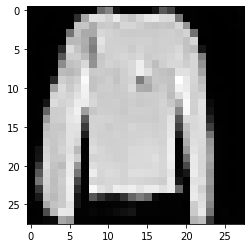

In [67]:
# 找一个图看看，这应该是个衣服吧。。。
random_index = 3
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

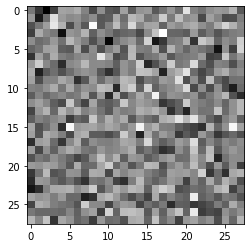

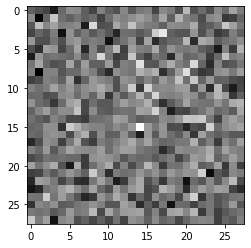

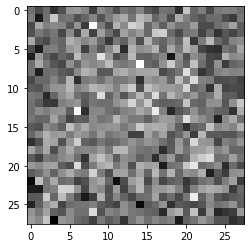

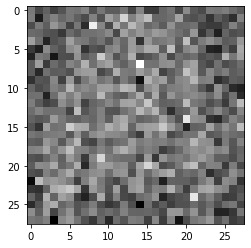

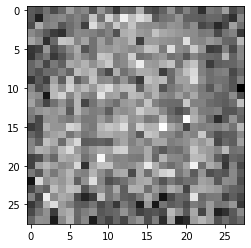

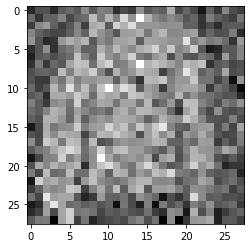

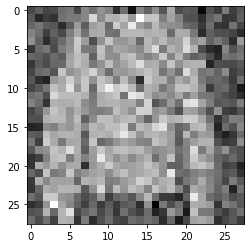

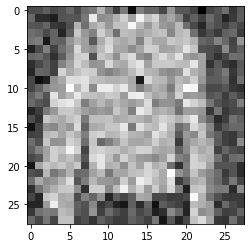

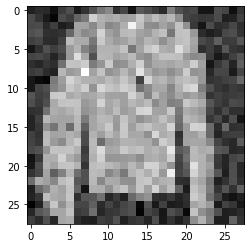

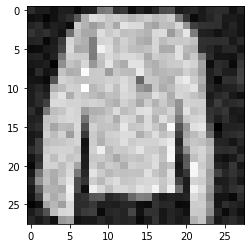

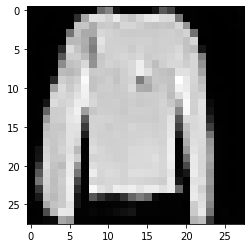

In [68]:
import matplotlib.animation as animation# GIF

random_index = 3

fig = plt.figure()
ims = []
for i in range(timesteps):
    im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), cmap="gray", animated=True)
    ims.append([im])
    if i % 20 ==0:
        plt.show()
animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
animate.save('diffusion.gif')